# Amazon Review Classification

### Aim
Classify Amazon Reviews into 1 star or 5 star categories based off the text content in the reviews.

### Dataset
[Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013)

### Information about the dataset

- Each observation in this dataset is a review of a particular business by a particular user.

- The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

- The "cool" column is the number of "cool" votes this review received from other Yelp users. 

- All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

- The "useful" and "funny" columns are similar to the "cool" column.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
import string

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Importing the data

In [2]:
amazon = pd.read_csv('MOBILEPHONE.csv')

In [3]:
amazon.shape

(186016, 6)

In [4]:
amazon.head()

,Title,Author,ReviewID,Overall,Content,Date
0,Great,Dustin,RYYNWQWW6LAC1,5,Product came exactly as described and would re...,41708.0
1,Excellent phone.,Lancerman,R2G160TW2JWGD8,5,I am very pleased with the phone we received. ...,41725.0
2,As described and a great phone,Maranda,R3P9IS2JNG68K2,5,The Samsung Galazy S3 is one of the best phone...,41732.0
3,nice television for the price,Jackie C,R3LDJA7HU2Q0FS,4,"The television was a refurbished one, and for ...",41742.0
4,Service and product quality very good.,Sonja Trokey,RAQB0MR9LGA2G,4,Delivery was very prompt. The picture of this...,41730.0


In [5]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186016 entries, 0 to 186015
Data columns (total 6 columns):
Title       186011 non-null object
Author      185714 non-null object
ReviewID    186016 non-null object
Overall     186016 non-null int64
Content     185993 non-null object
Date        186015 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 8.5+ MB


In [6]:
amazon.describe()

,Overall,Date
count,186016.000000,186015.000000
mean,3.634908,41308.040916
std,1.563230,534.339029
min,1.000000,36690.000000
25%,2.000000,41196.000000
50%,4.000000,41459.000000
75%,5.000000,41648.000000
max,5.000000,41803.000000


**Create a new column called "text length" which is the number of words in the "text" column.**

In [7]:
amazon['text length'] = amazon['Content'].str.len()

In [8]:
amazon.head()

,Title,Author,ReviewID,Overall,Content,Date,text length
0,Great,Dustin,RYYNWQWW6LAC1,5,Product came exactly as described and would re...,41708.0,138.0
1,Excellent phone.,Lancerman,R2G160TW2JWGD8,5,I am very pleased with the phone we received. ...,41725.0,943.0
2,As described and a great phone,Maranda,R3P9IS2JNG68K2,5,The Samsung Galazy S3 is one of the best phone...,41732.0,121.0
3,nice television for the price,Jackie C,R3LDJA7HU2Q0FS,4,"The television was a refurbished one, and for ...",41742.0,223.0
4,Service and product quality very good.,Sonja Trokey,RAQB0MR9LGA2G,4,Delivery was very prompt. The picture of this...,41730.0,139.0


# Exploratory data analysis

Compare text length for each star rating (using histograms and boxplot)

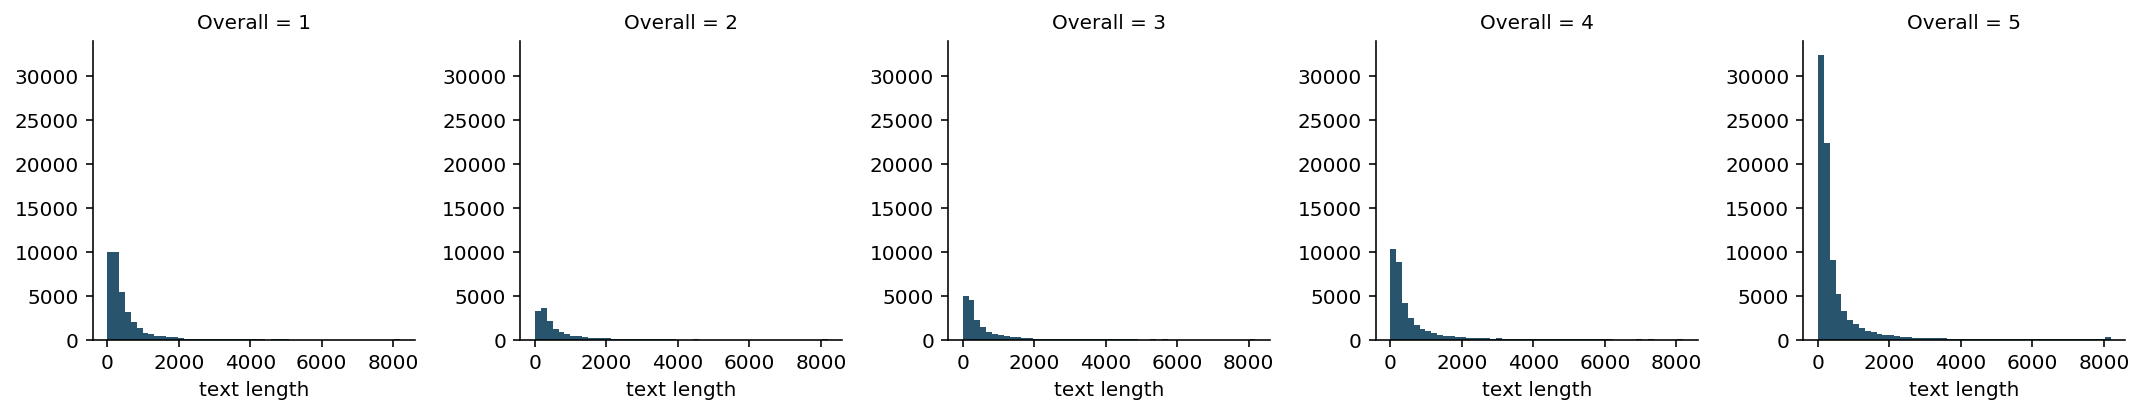

In [9]:
g = sns.FacetGrid(data=amazon, col='Overall')
g.map(plt.hist, 'text length', bins=50, color='#28546E')
plt.savefig('stars_textlen', dpi=200)

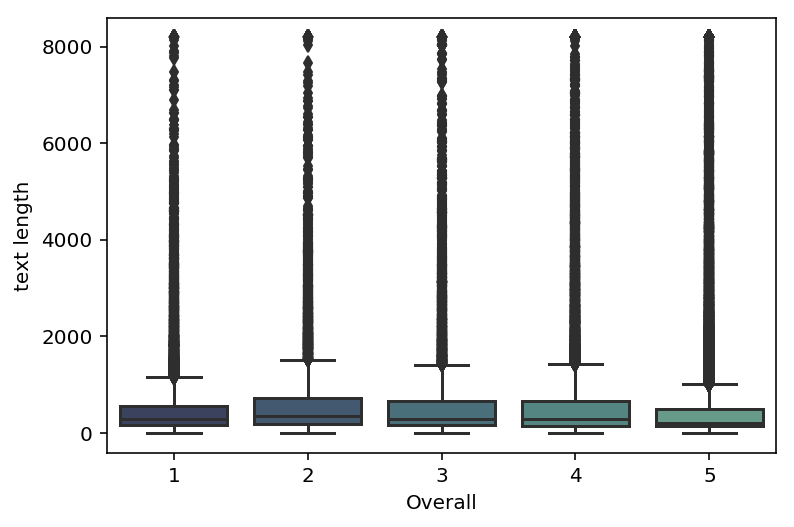

In [10]:
sns.boxplot(x='Overall', y='text length', data=amazon, palette=sns.cubehelix_palette(9, start=.4, rot=-.70, reverse=True, light=0.85, dark=0.25))
plt.savefig('stars_textlen_box', dpi=200)

Create a countplot of the number of occurrences for each type of star rating.

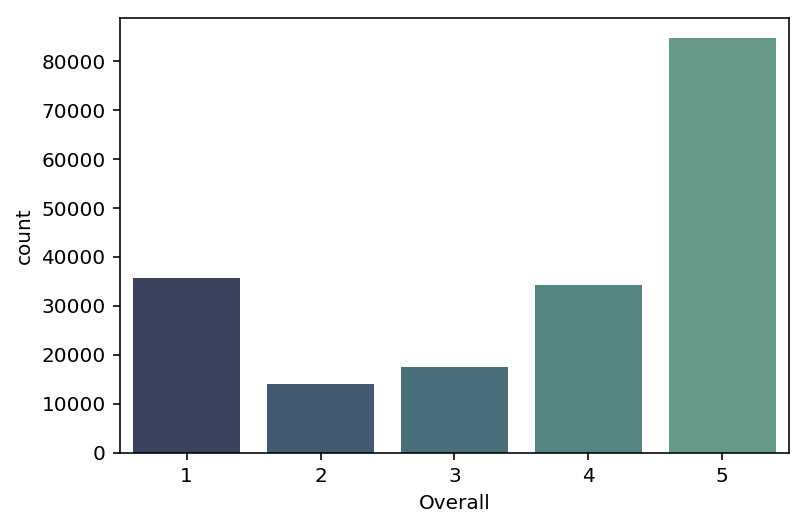

In [11]:
sns.countplot(x='Overall', data=amazon, palette=sns.cubehelix_palette(9, start=.4, rot=-.70, reverse=True, light=0.85, dark=0.25))

**Get the mean values of the numerical columns**

Find correlations between numeric columns in the stars dataframe

## NLP Classification Task

Create a dataframe for only the 1 or 5 star reviews.

In [12]:
amazon_class = amazon[(amazon['Overall'] == 1) | (amazon['Overall'] == 5)]

In [13]:
amazon_class.head()

,Title,Author,ReviewID,Overall,Content,Date,text length
0,Great,Dustin,RYYNWQWW6LAC1,5,Product came exactly as described and would re...,41708.0,138.0
1,Excellent phone.,Lancerman,R2G160TW2JWGD8,5,I am very pleased with the phone we received. ...,41725.0,943.0
2,As described and a great phone,Maranda,R3P9IS2JNG68K2,5,The Samsung Galazy S3 is one of the best phone...,41732.0,121.0
5,Don't buy it!,RrB,R2SNXGY9Z3IRMR,1,This phone is the biggest piece of junk I have...,40905.0,1284.0
6,Great Buy if you don't want to be Suckered int...,Peter,RI8F7YL5KZ7TB,5,"From the Moment I opened the box, I fell head ...",40497.0,174.0


In [14]:
amazon_class.shape

(120316, 7)

In [15]:
amazon_class['Overall'].unique()

array([5, 1])

Separate data into X and y

In [16]:
X = amazon_class['Content']
y = amazon_class['Overall']

In [17]:
X[0]

'Product came exactly as described and would recommend getting this if you like yourself a galaxy s3 and I would give this product a 5 star'

## Text processing
Remove stopwords and punctuations, then return a vector of tokens

In [18]:
nltk.download('stopwords')
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    if type(text) == float:
        text = str(text)
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/divyabharti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
X[0]
print(text_process(X[0]))

['Product', 'came', 'exactly', 'described', 'would', 'recommend', 'getting', 'like', 'galaxy', 's3', 'would', 'give', 'product', '5', 'star']


## Vectorisation

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)

In [22]:

print('what')
print(len(bow_transformer.vocabulary_))

what
186926


In [23]:
review25 = X[24]
print(review25)

I love it except that it is too big for my small New York appartment. Ideal if you have space.


In [24]:
bow25 = bow_transformer.transform([review25])
print(bow25)
print(bow25.shape)

  (0, 28501)	1
  (0, 35573)	1
  (0, 54382)	1
  (0, 60377)	1
  (0, 65902)	1
  (0, 94758)	1
  (0, 121100)	1
  (0, 160623)	1
  (0, 162524)	1
(1, 186926)


In [25]:
print(bow_transformer.get_feature_names()[28501])
print(bow_transformer.get_feature_names()[35573])

Ideal
New


In [26]:
X = bow_transformer.transform(X)

In [27]:
X

<120316x186926 sparse matrix of type '<class 'numpy.int64'>'
	with 4813399 stored elements in Compressed Sparse Row format>

In [28]:
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurences: ', X.nnz)

Shape of Sparse Matrix:  (120316, 186926)
Amount of Non-Zero occurences:  4813399


In [29]:
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('density: {}'.format((density)))

density: 0.021402217127586227


## Train Test Split
Test size: 30%

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Build and train model
Multinomial Naive Bayes model

In [32]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [33]:
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predictions and Evaluations
Predictions

In [53]:
prediction = dict()
prediction['Multinomial'] = nb.predict(X_test)
preds = nb.predict(X_test)

In [35]:
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[ 9562  1221]
 [ 1654 23658]]


             precision    recall  f1-score   support

          1       0.85      0.89      0.87     10783
          5       0.95      0.93      0.94     25312

avg / total       0.92      0.92      0.92     36095



In [46]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train,y_train) 

In [54]:
prediction['Bernoulli'] = model.predict(X_test)
predsBNB = model.predict(X_test)

In [48]:
print(confusion_matrix(y_test, predsBNB))
print('\n')
print(classification_report(y_test, predsBNB))

[[ 9004  1779]
 [ 1122 24190]]


             precision    recall  f1-score   support

          1       0.89      0.84      0.86     10783
          5       0.93      0.96      0.94     25312

avg / total       0.92      0.92      0.92     36095



In [55]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train, y_train)
prediction['Logistic'] = logreg.predict(X_test)
predsLR = logreg.predict(X_test)

In [50]:
print(confusion_matrix(y_test, predsLR))
print('\n')
print(classification_report(y_test, predsLR))

[[ 9551  1232]
 [ 1169 24143]]


             precision    recall  f1-score   support

          1       0.89      0.89      0.89     10783
          5       0.95      0.95      0.95     25312

avg / total       0.93      0.93      0.93     36095



In [57]:
from sklearn.metrics import roc_curve,auc

def formatt(x):
    if x == 'negative':
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

/Users/divyabharti/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


ValueError: At least 2 points are needed to compute area under curve, but x.shape = 1

In [38]:
positive_review = amazon_class['Content'][59]
positive_review

'-poor reception-misses calls even when it is "in range"Generally cheap.  My display has accumulated debris inside the phone so I can\'t clean it out and it is difficult to read.  When talking to someone it cuts in and out.Paying anything for this phone is '

In [39]:
positive_review_transformed = bow_transformer.transform([positive_review])
positive_review_transformed

<1x186926 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [40]:
nb.predict(positive_review_transformed)[0]

1

In [51]:
model.predict(positive_review_transformed)[0]

1

In [42]:
negative_review = amazon_class['Content'][281]
negative_review

'Hello, thank you guys for sharing very useful information about this phone. Here are some new tricks that i found recently:1. In address book, a contact person is not restricted to 4 fields(home, office, cell and email address) only. You can put as much as you want about contact information of one person, say, some person might have more than 1 email address or more than 1 office phone number. Here is how to do: go to the contact person, select Option/Add Entry then you can add any information you want such as new email or work phone. Off course, it will eat up one spot in the memory.2. Customize your email address: your cell-email that your friend send sms to, have the form ten_digit_phone@tmomail.net, for instance 850339XXXX@tmomail.net, you can change to easy-to-remember-email such as yourname@tmomail.net. Here is how to do it: Go to t-mobile.com, log in then select "Communication" tab, select "Text Messaging", on the left window, at "Power Messaging feature", select "Change my pho

In [43]:
negative_review_transformed = bow_transformer.transform([negative_review])
negative_review_transformed

<1x186926 sparse matrix of type '<class 'numpy.int64'>'
	with 119 stored elements in Compressed Sparse Row format>

In [44]:
nb.predict(negative_review_transformed)[0]

1